In [633]:
# imports for data processing
import pandas as pd
import glob
import pandas as pd
import numpy as np
import datetime
import math
from ast import literal_eval
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
from ast import literal_eval

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# imports for logistic regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split

In [634]:
# Functions
def ct_numbers_list(ct_numbers_in_heart):
    ls = literal_eval(ct_numbers_in_heart)
    ints = list()
    for x in ls:
        ints.append(int(x))
    return(ints)


def consolidate_data(df, included_cacs):
    d = list()
    for patient_id in df.pt_id.unique():
        dfp = df[df.pt_id == patient_id]

        data = {'patient_id': patient_id,
                'total_score': dfp.total_score.max(),
                'label': 1 if dfp.total_score.max() >= 100 else 0,
                'total_hhua_pixels':dfp.number_of_pixels.sum(),
                'cts_with_cac': len(dfp.ct_number.unique()),
                'slice_thickness': dfp.slice_thickness.max(),
                'pixel_spacing_1': dfp.pixel_spacing_1.max(),
                }
                
        dfp.sort_values(by=['number_of_pixels'])
        dfp = dfp.reset_index()

        dfp['center_lit'] = dfp.center_min_circle.apply(literal_eval)
        dfp['center_1'] = 0
        dfp['center_2'] = 0
        dfp.loc[:, 'center_1'] = dfp.center_lit.map(lambda x: x[0])
        dfp.loc[:, 'center_2'] = dfp.center_lit.map(lambda x: x[1])

        dfp['cropedlit'] = dfp.croped_slice_shape.apply(literal_eval)
        dfp['croped_1'] = 0
        dfp['croped_2'] = 0
        dfp.loc[:, 'croped_1'] = dfp.cropedlit.map(lambda x: x[0])
        dfp.loc[:, 'croped_2'] = dfp.cropedlit.map(lambda x: x[1])
     
        for i in range(included_cacs):
            try:
                data[f'hhua_{i}_area'] = dfp.iloc[i].number_of_pixels  * data['pixel_spacing_1']**2 

                data[f'hhua_{i}_dist_x1'] = dfp.iloc[i]['center_1'] * data['pixel_spacing_1']
                data[f'hhua_{i}_dist_x2'] = (dfp.iloc[i]['croped_1'] - dfp.iloc[i]['center_1'])* data['pixel_spacing_1']

                data[f'hhua_{i}_dist_y1'] = dfp.iloc[i]['center_2'] * data['pixel_spacing_1']
                data[f'hhua_{i}_dist_y2'] = (dfp.iloc[i]['croped_2'] - dfp.iloc[i]['center_2'])* data['pixel_spacing_1']

                data[f'hhua_{i}_dist_z1'] = (dfp.iloc[i].ct_max - dfp.iloc[i].ct_number) * data['slice_thickness']
                data[f'hhua_{i}_dist_z2'] = (dfp.iloc[i].ct_number - dfp.iloc[i].ct_min ) * data['slice_thickness']

                data[f'hhua_{i}_ct_number'] = dfp.iloc[i].ct_number

                data[f'hhua_{i}_max_pixel_value'] = dfp.iloc[i].max_pixel_value
                data[f'hhua_{i}_min_pixel_value'] = dfp.iloc[i].min_pixel_value
                data[f'hhua_{i}_mean_pixel_value'] = dfp.iloc[i].mean_pixel_value
                
            except IndexError:
                data[f'hhua_{i}_area'] = 0
                data[f'hhua_{i}_ct_number'] = 0
                data[f'hhua_{i}_dist_x1'] = 0
                data[f'hhua_{i}_dist_y1'] = 0
                data[f'hhua_{i}_dist_z1'] = 0
                data[f'hhua_{i}_dist_x2'] = 0
                data[f'hhua_{i}_dist_y2'] = 0
                data[f'hhua_{i}_dist_z2'] = 0
                data[f'hhua_{i}_max_pixel_value'] = 0
                data[f'hhua_{i}_min_pixel_value'] = 0
                data[f'hhua_{i}_mean_pixel_value'] = 0

        d.append(data)
    return(d)    

In [ ]:
df_patients = pd.read_csv("DSproject/patient_overview_train.csv")
df_manual = pd.read_csv("DSproject/manual_labels_train.csv")
df_slices = pd.read_csv("DSproject/ct_slices_train.csv")

df_patients = pd.merge(df_patients, df_manual[['pt_id', 'Total_score']], on='pt_id')
df_patients['ct_list'] = df_patients.ct_numbers_in_heart.apply(ct_numbers_list)
df_patients['ct_max'] = df_patients.ct_list.apply(max)
df_patients['ct_min'] = df_patients.ct_list.apply(min)
df_patients['ct_len'] = df_patients.ct_list.apply(len)

df_slices['number_of_pixels'] = df_slices.pixel_values_hu.apply(literal_eval).apply(len)
df_slices['max_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(max)
df_slices['min_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(min)
df_slices['mean_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(np.mean)

# apply the same total score to all slices of the same patient
df_slices['total_score'] = 0
for patient_id in df_slices.pt_id.unique():
    df_slices.loc[(df_slices.pt_id == patient_id), 'total_score'] = df_patients.loc[(df_patients.pt_id == patient_id), 'Total_score'].values[0]

df_slices['ct_max']= 0
df_slices['ct_min'] =0

for patient_id in df_slices.pt_id.unique():
    df_slices.loc[(df_slices.pt_id == patient_id), 'ct_max'] = df_patients.loc[(df_patients.pt_id == patient_id), 'ct_max'].values[0]
    df_slices.loc[(df_slices.pt_id == patient_id), 'ct_min'] = df_patients.loc[(df_patients.pt_id == patient_id), 'ct_min'].values[0]

In [636]:
number_of_lessions_to_include = 1

df_features = pd.DataFrame(consolidate_data(df_slices, number_of_lessions_to_include))

df_features

,patient_id,total_score,label,total_hhua_pixels,cts_with_cac,slice_thickness,pixel_spacing_1,hhua_0_area,hhua_0_dist_x1,hhua_0_dist_x2,hhua_0_dist_y1,hhua_0_dist_y2,hhua_0_dist_z1,hhua_0_dist_z2,hhua_0_ct_number,hhua_0_max_pixel_value,hhua_0_min_pixel_value,hhua_0_mean_pixel_value
0,123,17.5,0,44,3,2.5,1.269531,9.670254,55.859364,24.121089,40.624992,31.738275,80.0,15.0,81,272.0,140.0,203.666667
1,264,683.6,1,357,8,2.5,1.269531,41.904433,21.582027,57.128895,45.703116,54.589833,75.0,12.5,100,383.0,130.0,209.384615
2,1053,0.0,0,165,2,2.5,1.269531,12.893672,46.972647,29.199213,71.093736,44.433585,12.5,80.0,109,157.0,131.0,142.750000
3,1115,0.0,0,16,2,2.5,1.269531,12.893672,20.312496,54.589833,10.156248,76.171860,87.5,12.5,91,155.0,130.0,144.750000
4,1171,0.0,0,9,1,2.5,1.269531,14.505381,82.519515,36.816399,96.484356,39.355461,62.5,20.0,86,223.0,137.0,175.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1047,0.0,0,16,2,3.0,0.976562,4.768372,92.773438,6.835938,8.789062,105.468750,45.0,69.0,93,160.0,132.0,148.000000
1311,1287,0.0,0,7,1,3.0,0.976562,6.675720,0.000000,66.406250,25.390625,53.710938,87.0,0.0,62,162.0,137.0,151.285714
1312,441,177.4,1,192,10,3.0,0.976562,7.629395,53.710938,34.179688,34.179688,55.664062,78.0,12.0,81,204.0,140.0,174.750000
1313,1083,0.0,0,75,5,3.0,0.976562,8.583069,19.531250,66.406250,76.171875,1.953125,69.0,21.0,68,192.0,136.0,160.888889


In [326]:
# do PCA on the data with only one HHUA (high hounsfield unit area (one lesion per patient))

X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.label.values

# Z-score the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA(n_components=len(X[0,:]))
X_new = pca.fit_transform(X) # project the original data into the PCA space

Text(0, 0.5, 'Explained variance')

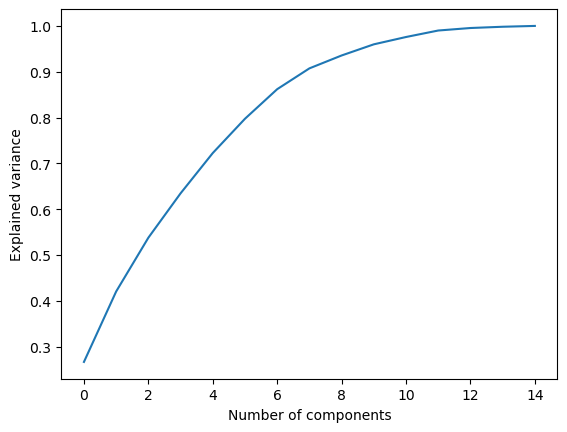

In [330]:
# plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

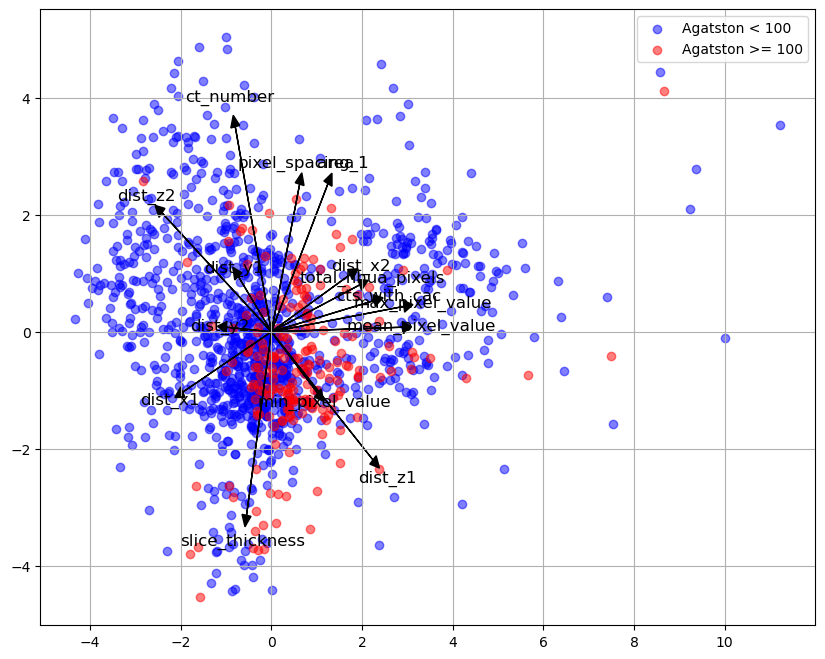

In [336]:
def create_biplot(data, labels, pca, features):
    fig, ax = plt.subplots(figsize=(10, 8))

    classes = np.unique(labels)
    colors = ['blue', 'red']  # changed colors for better visibility
    for label, color in zip(classes, colors):
        x = data[labels == label, 0]
        y = data[labels == label, 1]
        ax.scatter(x, y, color=color, alpha=0.5)

    feature_vectors = pca.components_.T
    arrow_size, text_pos = 7.0, 8.0,
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                 head_width=0.2, head_length=0.2, linewidth=1, color='black')  # changed arrow color to black for better visibility
        ax.text(v[0]*text_pos, v[1]*text_pos, features[i], color='black', 
                ha='center', va='center', fontsize=12)

    ax.grid()
    plt.legend(['Agatston < 100', 'Agatston >= 100'])
    plt.show()

def fit_pca(data, n_components):
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    return transformed_data, pca, explained_variance

# Fit the PCA model and transform X
X_new, pca, explained_variance = fit_pca(X, len(X[0]))

# Sort the features based on the explained variance
features_sorted = [feature.replace('hhua_0_', '') for _, feature in sorted(zip(explained_variance, df_features.columns[3:]), reverse=True)]

# Create biplot
create_biplot(X_new, y, pca, features_sorted)

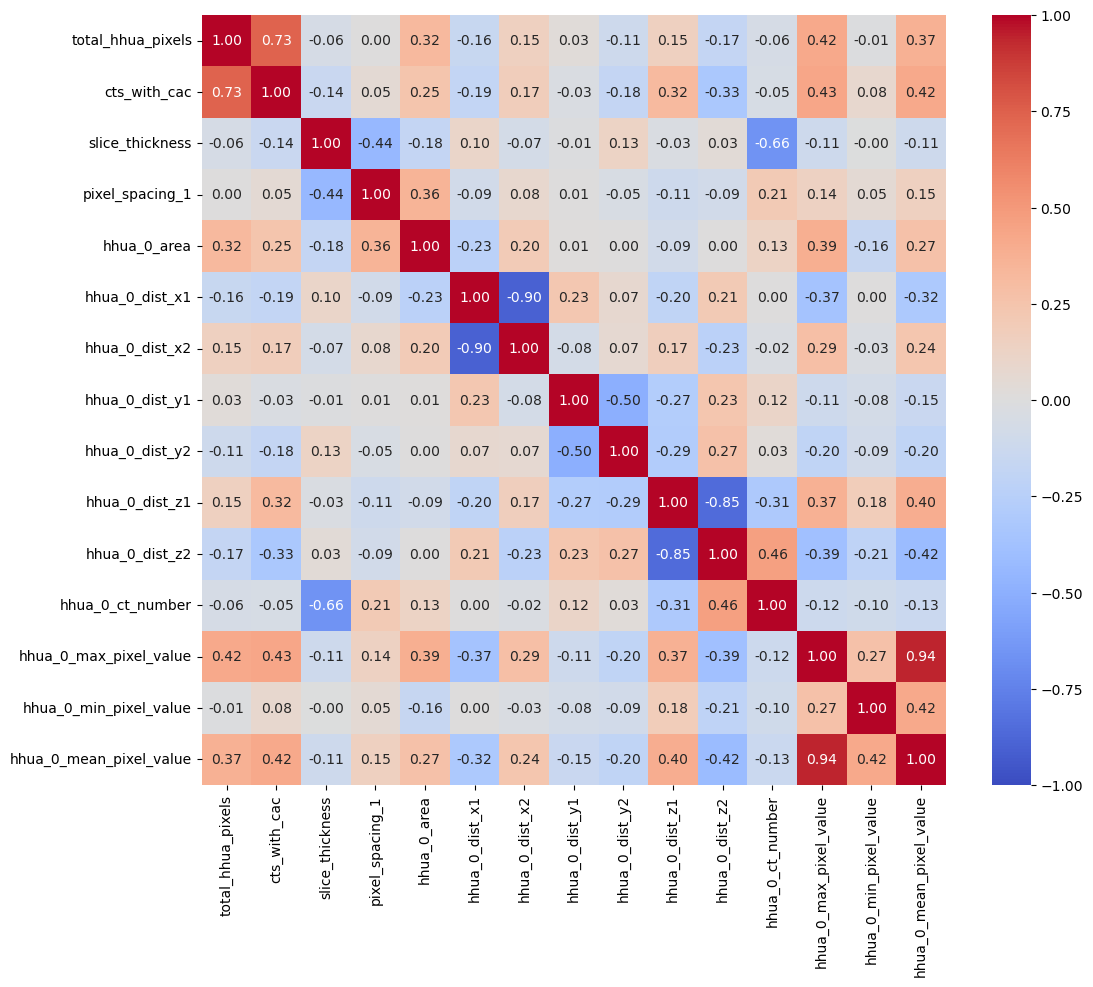

In [340]:
# Calculate the correlation matrix
corr = df_features.drop(columns=['patient_id', 'total_score', 'label']).corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.show()

In [618]:
# Given the results of PCA, we can see that dimensionality reduction is not very useful in this case.
# most of the components are important for the classification task.

# Let's try to use the original (not using PCA) features to train a logistic regression model to predict the label (0: Agatston < 100, 1: Agatston >= 100)

# We first create the dataframe with all potential CACs included

# The amount of rows for a patient is the amount of HHUAs (High Houndsfield Unit Areas) in that patients heart, 
# which is the amount of potential CACs (Coronary Artery Calcification) in the heart.

# The max amount of cacs in a patient is 158, so we will use this number to create the dataframe
df_features = pd.DataFrame(consolidate_data(df_slices, 158))

# We remove the patients with slice thickness 5.0, since this data is from outdated CT scanners. 
# Slice thickness 5.0 will not be representative for future ct scans fed to the model.
df_features = df_features[df_features.slice_thickness != 5.0]

In [623]:
df_features

,patient_id,total_score,label,total_hhua_pixels,cts_with_cac,slice_thickness,pixel_spacing_1,hhua_0_area,hhua_0_dist_x1,hhua_0_dist_x2,...,hhua_157_ct_number,hhua_157_dist_x1,hhua_157_dist_y1,hhua_157_dist_z1,hhua_157_dist_x2,hhua_157_dist_y2,hhua_157_dist_z2,hhua_157_max_pixel_value,hhua_157_min_pixel_value,hhua_157_mean_pixel_value
0,123,17.5,0,44,3,2.5,1.269531,9.670254,55.859364,24.121089,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,264,683.6,1,357,8,2.5,1.269531,41.904433,21.582027,57.128895,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1053,0.0,0,165,2,2.5,1.269531,12.893672,46.972647,29.199213,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1115,0.0,0,16,2,2.5,1.269531,12.893672,20.312496,54.589833,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1171,0.0,0,9,1,2.5,1.269531,14.505381,82.519515,36.816399,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1047,0.0,0,16,2,3.0,0.976562,4.768372,92.773438,6.835938,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1311,1287,0.0,0,7,1,3.0,0.976562,6.675720,0.000000,66.406250,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1312,441,177.4,1,192,10,3.0,0.976562,7.629395,53.710938,34.179688,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1313,1083,0.0,0,75,5,3.0,0.976562,8.583069,19.531250,66.406250,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


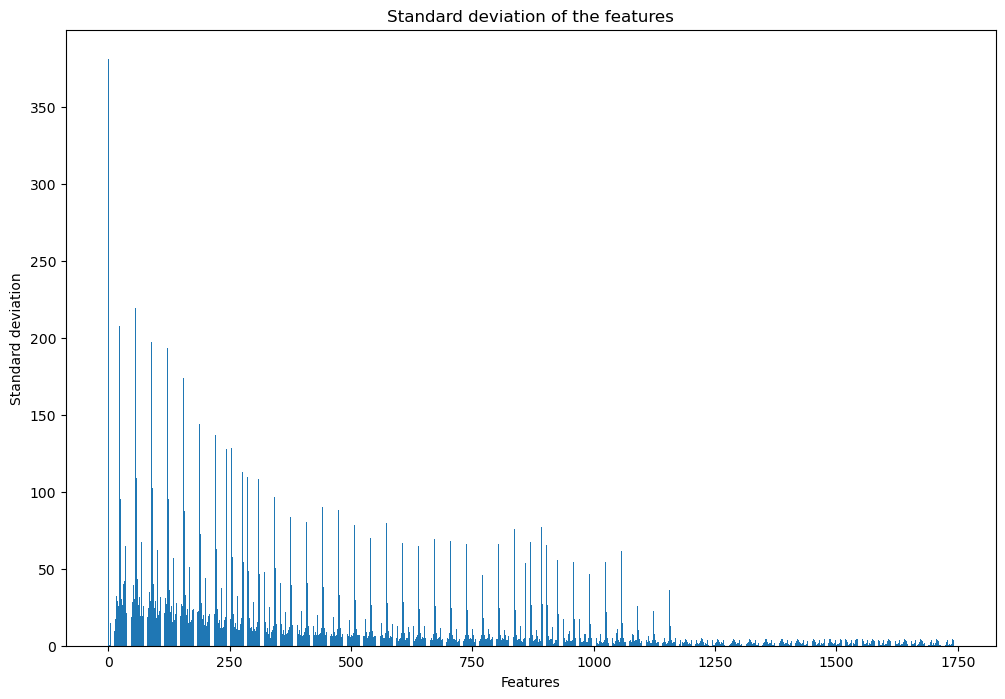

In [343]:
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values

# create a standard deviation plot
# no labels are needed for this plot for readability

plt.figure(figsize=(12, 8))
std = np.std(X, axis=0)
features = X.shape[1]
plt.bar(range(features), std)
plt.xlabel('Features')
plt.ylabel('Standard deviation')
plt.title('Standard deviation of the features')
plt.show()

In [344]:
# We can see that the distribution is heterogenous (some features have high standard deviation, some have low standard deviation), 
# so we will benefit from scaling the features before training the model.

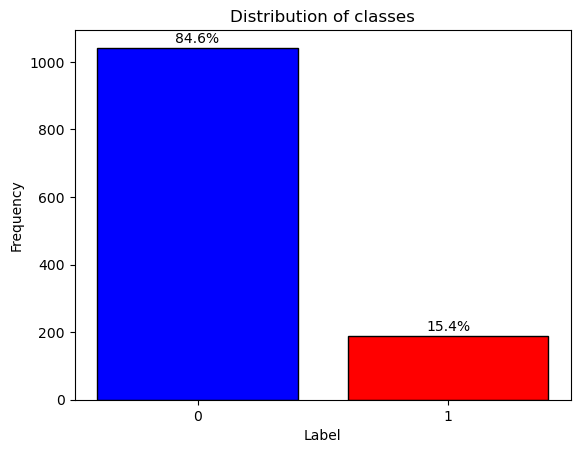

In [624]:
# Calculate the counts and percentages
counts = df_features.label.value_counts()
percentages = counts / len(df_features) * 100

# Specify colors
colors = ['blue' if label == 0 else 'red' for label in counts.index]

# Plot the distribution of classes
plt.bar(counts.index, counts, color=colors, edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of classes')

# Add the percentages to the plot
for i in range(len(counts)):
    plt.text(i, counts[i] + 5, f'{percentages[i]:.1f}%', ha='center', va='bottom')

plt.show()

In [637]:
# We see that the classes are imbalanced, meaning that a naive classifier that always predicts 0 (Agatston < 100) will have an accuracy of roughly 85%.
# To avoid the model to be biased towards the majority class, we will add class weights to the logistic regression model.
# This is also beneficial since false negatives are more costly than false positives in this case.

# At the same time we don't want the model to be too biased towards the minority class (Agatston >= 100), 
# since we also want a reasonable amount of true positives. We will therefore use a balanced class weight.

# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

weight_for_0 = np.sum(counts) / (2 * counts[0])
weight_for_1 = np.sum(counts) / (2 * counts[1])

weights = {0: weight_for_0, 1: weight_for_1}
print(weights)

# We will also be using L1 lasso regularization to avoid overfitting and to select the most important features.
# To find the best regularization parameter, we will use cross-validation.

{0: 0.5906909788867563, 1: 3.2566137566137567}


In [543]:
# Define the K-fold cross validator
kfold = KFold(n_splits=10, shuffle=True)

# Define the C values to test
C_values = np.logspace(-5, 1, 40)

mean_errors_train = []
mean_errors_test = []

X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.label.values

# For each C value
for C in C_values:
    print(f"Progress: {len(mean_errors_test)+1} / {len(C_values)}")
    fold_errors_train = []
    fold_errors_test = []
    
    # For each fold
    for train_index, val_index in kfold.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # scale the features
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        # Create a logistic regression model with L1 penalty
        model = LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=1000, class_weight=weights)
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on the training and validation sets
        y_pred_train = model.predict_proba(X_train_fold)[:, 1]
        y_pred_test = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate the errors
        error_train = log_loss(y_train_fold, y_pred_train)
        error_test = log_loss(y_val_fold, y_pred_test)
        
        # Record the errors
        fold_errors_train.append(error_train)
        fold_errors_test.append(error_test)
    
    # Calculate the mean errors for this C value
    mean_error_train = np.mean(fold_errors_train)
    mean_error_test = np.mean(fold_errors_test)
    mean_errors_train.append(mean_error_train)
    mean_errors_test.append(mean_error_test)

Progress: 1 / 40
Progress: 2 / 40
Progress: 3 / 40
Progress: 4 / 40
Progress: 5 / 40
Progress: 6 / 40
Progress: 7 / 40
Progress: 8 / 40
Progress: 9 / 40
Progress: 10 / 40
Progress: 11 / 40
Progress: 12 / 40
Progress: 13 / 40
Progress: 14 / 40
Progress: 15 / 40
Progress: 16 / 40
Progress: 17 / 40
Progress: 18 / 40
Progress: 19 / 40
Progress: 20 / 40
Progress: 21 / 40
Progress: 22 / 40
Progress: 23 / 40
Progress: 24 / 40
Progress: 25 / 40
Progress: 26 / 40
Progress: 27 / 40
Progress: 28 / 40
Progress: 29 / 40
Progress: 30 / 40
Progress: 31 / 40
Progress: 32 / 40
Progress: 33 / 40
Progress: 34 / 40
Progress: 35 / 40
Progress: 36 / 40
Progress: 37 / 40
Progress: 38 / 40
Progress: 39 / 40
Progress: 40 / 40


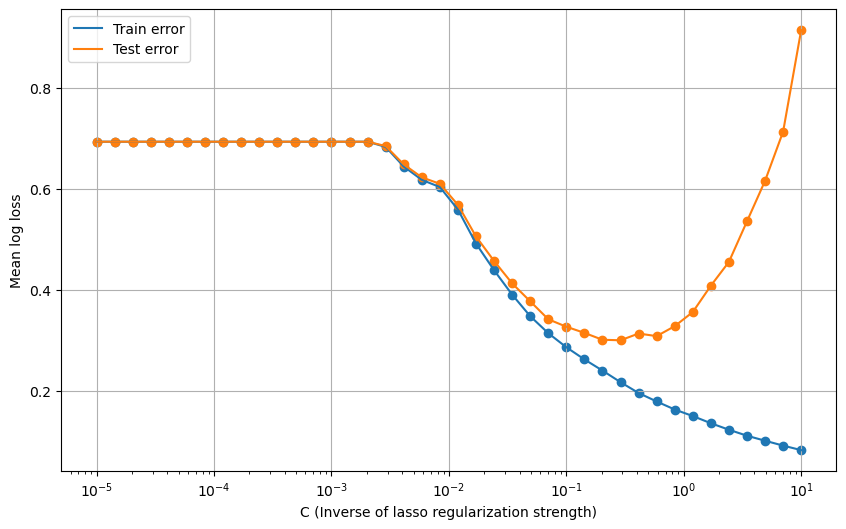

In [544]:
# Plot the mean errors for each C
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, mean_errors_train, label='Train error') 
plt.semilogx(C_values, mean_errors_test, label='Test error')
plt.scatter(C_values, mean_errors_train)
plt.scatter(C_values, mean_errors_test)
plt.xlabel('C (Inverse of lasso regularization strength)')
plt.ylabel('Mean log loss')
plt.legend()
plt.grid(True)
plt.show()

In [638]:
# pick the best C value
best_C = C_values[np.argmin(mean_errors_test)]
print(f'Best C value: {best_C}, Mean error test: {min(mean_errors_test)}')

Best C value: 0.28942661247167517, Mean error test: 0.3002568097194091


In [627]:
# We build the final model using the best C value and all the data
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(C=best_C, penalty='l1', solver='liblinear', max_iter=1000, class_weight=weights)
model.fit(X_train, y_train)

LogisticRegression(C=0.28942661247167517,
                   class_weight={0: 0.5906909788867563, 1: 3.2566137566137567},
                   max_iter=1000, penalty='l1', solver='liblinear')

C:\Users\frede\AppData\Local\Temp\ipykernel_2644\3666898400.py:26: RuntimeWarning: invalid value encountered in scalar divide
  positive_prediction_rate = tp / (tp + fp)
C:\Users\frede\AppData\Local\Temp\ipykernel_2644\3666898400.py:25: RuntimeWarning: invalid value encountered in scalar divide
  negative_prediction_rate = tn / (tn + fn)


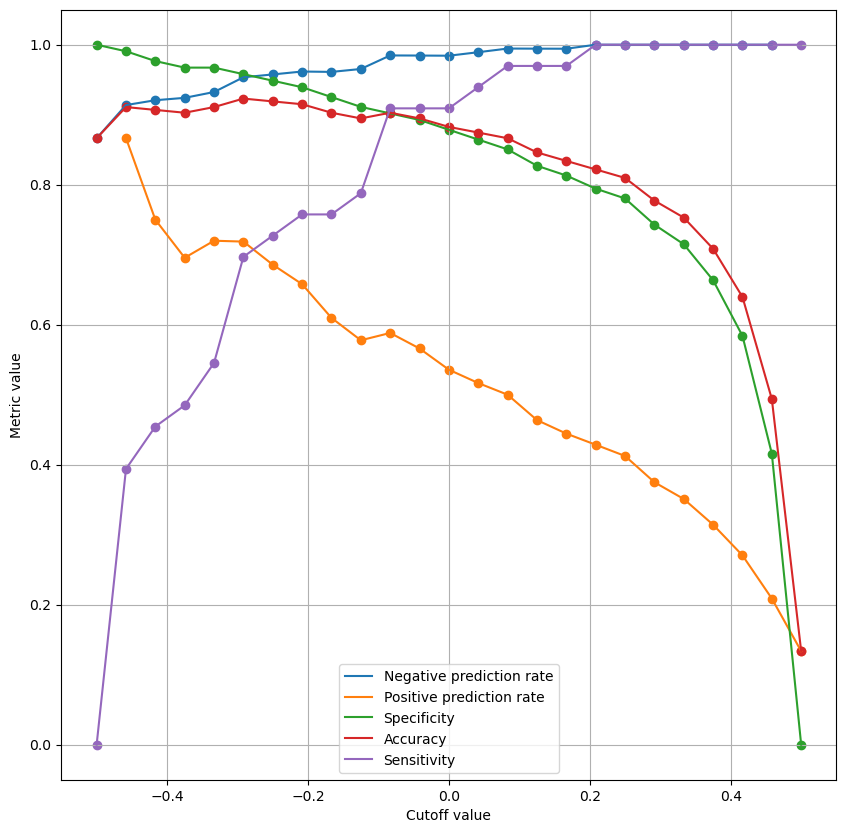

In [628]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

cutoff_values = np.linspace(-0.5, 0.5, 25)

# Predict the probabilities of the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Initialize lists to store the metrics
negative_prediction_rates = []
positive_prediction_rates = []
specificities = []
accuracies = []
sensitivities = []

# For each cutoff value
for cutoff in cutoff_values:
    # Convert probabilities to class predictions
    y_pred = np.where(y_pred_proba > 0.5 - cutoff, 1, 0)
    
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate the metrics
    negative_prediction_rate = tn / (tn + fn)
    positive_prediction_rate = tp / (tp + fp)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_pred, y_test)
    sensitivity = tp / (tp + fn)
    
    # Record the metrics
    negative_prediction_rates.append(negative_prediction_rate)
    positive_prediction_rates.append(positive_prediction_rate)
    specificities.append(specificity)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)

# Plot the metrics
plt.figure(figsize=(10, 10))
plt.plot(cutoff_values, negative_prediction_rates, label='Negative prediction rate')
plt.plot(cutoff_values, positive_prediction_rates, label='Positive prediction rate')
plt.plot(cutoff_values, specificities, label='Specificity')
plt.plot(cutoff_values, accuracies, label='Accuracy')
plt.plot(cutoff_values, sensitivities, label='Sensitivity')
plt.scatter(cutoff_values, negative_prediction_rates)
plt.scatter(cutoff_values, positive_prediction_rates)
plt.scatter(cutoff_values, specificities)
plt.scatter(cutoff_values, accuracies)
plt.scatter(cutoff_values, sensitivities)
plt.xlabel('Cutoff value')
plt.ylabel('Metric value')
plt.legend()
plt.grid(True)
plt.show()

In [629]:
cutoff_values

array([-0.5       , -0.45833333, -0.41666667, -0.375     , -0.33333333,
       -0.29166667, -0.25      , -0.20833333, -0.16666667, -0.125     ,
       -0.08333333, -0.04166667,  0.        ,  0.04166667,  0.08333333,
        0.125     ,  0.16666667,  0.20833333,  0.25      ,  0.29166667,
        0.33333333,  0.375     ,  0.41666667,  0.45833333,  0.5       ])

Negative prediction rate: 0.9846938775510204
Positive prediction rate: 0.5882352941176471
Specificity: 0.9018691588785047
Accuracy: 0.902834008097166
Sensitivity: 0.9090909090909091


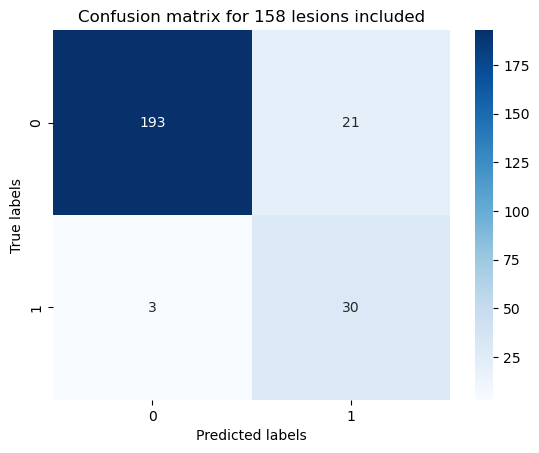

In [630]:
# we set the cutoff value to 0.5 - (-0.083)
c = -0.083

cutoff = 0.5 - c
y_pred = np.where(y_pred_proba > cutoff, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion matrix for 158 lesions included')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Calculate the metrics
tn, fp, fn, tp = cm.ravel()
negative_prediction_rate = tn / (tn + fn)
positive_prediction_rate = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_pred, y_test)
sensitivity = tp / (tp + fn)

print(f'Negative prediction rate: {negative_prediction_rate}')
print(f'Positive prediction rate: {positive_prediction_rate}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')

In [631]:
# Printing the coefficients of the model to see which features are important:
for i, feature in enumerate(df_features.columns[3:]):
    if model.coef_[0][i] != 0:
        print(f'{feature}: {model.coef_[0][i]}')

slice_thickness: 0.15073547228626116
pixel_spacing_1: 0.5404953803644491
hhua_0_dist_x1: 0.4358558105259632
hhua_0_dist_y1: -0.22266001623915513
hhua_0_dist_y2: -0.15636529832483959
hhua_0_dist_z1: -0.5776120408533386
hhua_0_dist_z2: -0.9211323001415913
hhua_0_max_pixel_value: 0.0636734649916797
hhua_0_min_pixel_value: 0.19953247633919552
hhua_1_area: -0.2608222132631003
hhua_1_dist_x1: 0.7658817265910695
hhua_1_dist_x2: 0.35372043786838936
hhua_1_dist_y1: -0.167577333400346
hhua_1_dist_z2: -0.3738124101212652
hhua_1_mean_pixel_value: 0.16255218119039713
hhua_2_dist_x1: 0.7266841165763283
hhua_2_dist_y1: -0.7037398606108044
hhua_2_dist_y2: -0.16412953729341745
hhua_2_dist_z2: -0.4667276341288928
hhua_2_max_pixel_value: 0.11102843375774593
hhua_2_min_pixel_value: 0.5371342519555414
hhua_3_dist_x1: 0.1723760837008453
hhua_3_dist_y1: -0.24606776211315756
hhua_3_dist_z1: 0.44251585011432754
hhua_3_dist_x2: 0.023196556450790065
hhua_3_dist_z2: -0.0330707533964621
hhua_3_min_pixel_value: 0.2

In [581]:
# We see that after 91 lesions included, the rest of the lesions and their features add no value to the model.
# lets try to train the model with only 91 lesions.

Negative prediction rate: 0.9846938775510204
Positive prediction rate: 0.5882352941176471
Specificity: 0.9018691588785047
Accuracy: 0.902834008097166
Sensitivity: 0.9090909090909091


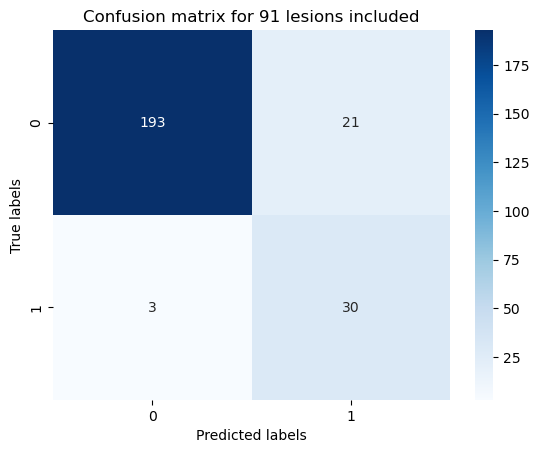

In [609]:
df_features = pd.DataFrame(consolidate_data(df_slices, 91))
df_features = df_features[df_features.slice_thickness != 5.0]

X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(C=best_C, penalty='l1', solver='liblinear', max_iter=1000, class_weight=weights)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > cutoff, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion matrix for 91 lesions included')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Calculate the metrics
tn, fp, fn, tp = cm.ravel()
negative_prediction_rate = tn / (tn + fn)
positive_prediction_rate = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_pred, y_test)
sensitivity = tp / (tp + fn)

print(f'Negative prediction rate: {negative_prediction_rate}')
print(f'Positive prediction rate: {positive_prediction_rate}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')

In [ ]:
# As expected the model performs the exact same with information from only 91 lesions.
# We should be able to use even less features to get the same performance:

Negative prediction rate: 0.9846938775510204
Positive prediction rate: 0.5882352941176471
Specificity: 0.9018691588785047
Accuracy: 0.902834008097166
Sensitivity: 0.9090909090909091


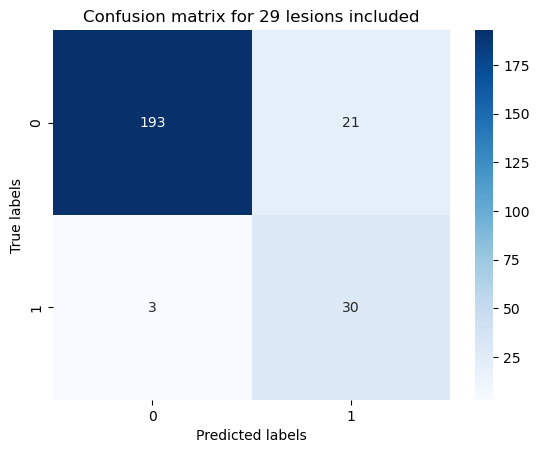

In [639]:
df_features = pd.DataFrame(consolidate_data(df_slices, 29))
df_features = df_features[df_features.slice_thickness != 5.0]

X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(C=best_C, penalty='l1', solver='liblinear', max_iter=1000, class_weight=weights)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > cutoff, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion matrix for 29 lesions included')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Calculate the metrics
tn, fp, fn, tp = cm.ravel()
negative_prediction_rate = tn / (tn + fn)
positive_prediction_rate = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_pred, y_test)
sensitivity = tp / (tp + fn)

print(f'Negative prediction rate: {negative_prediction_rate}')
print(f'Positive prediction rate: {positive_prediction_rate}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')

In [606]:
# As predicted the model performs the same with only 29 lesions included, which is only 323 features compared to the original 1742 features.
# This means that we can reduce the amount of inputs fed to the model by more than 80% without losing performance.

# Since this is a logistic regression model, it is fairly cheap to train and test, so we can afford to use all the data, 
# but when we switch to neural networks, this will be very useful since NNs are more computationally expensive and prone to overfitting with high dimensional data.

## Model 1

| Metric                   | Value  |
|--------------------------|--------|
| max_hhua                 | 158    |
| num_features             | 1742   |
| accuracy                 | 0.9028 |
| Sensitivity              | 0.9091 |
| Specificity              | 0.9019 |
| Positive prediction rate | 0.5882 |
| Negative prediction rate | 0.9847 |

## Model 2
| Metric                   | Value  |
|--------------------------|--------|
| max_hhua                 | 91   |
| num_features             | 994  |
| accuracy                 | 0.9028 |
| Sensitivity              | 0.9091 |
| Specificity              | 0.9019 |
| Positive prediction rate | 0.5882 |
| Negative prediction rate | 0.9847 |

## Model 3
| Metric                   | Value  |
|--------------------------|--------|
| max_hhua                 | 29     |
| num_features             | 323 |
| accuracy                 | 0.9028 |
| Sensitivity              | 0.9091 |
| Specificity              | 0.9019 |
| Positive prediction rate | 0.5882 |
| Negative prediction rate | 0.9847 |
